# Colorbot

**Special thanks to @MarkDaoust that helped us with this material**

## What is the content of this notebook?

In this notebook you'll find a full implementation of a RNN model using the TensorFlow High level API including comments and details about how to do it. Once you finish this notebook, you'll have a better understanding about:
  * TensorFlow High level API
  * TensorFlow DataSets
  * RNNs


## What is colorbot?

Colorbot is a RNN model that receives a sequence of characters as input and learns to predict a rgb value as output. As a result we have a color generator!

![colorbot in action](imgs/model_gif.gif)

## How the model looks like?

![img](imgs/colorbot_model.png)
![img](imgs/colorbot_execution.png)



## Dependencies

In [1]:
# Tensorflow
import tensorflow as tf
print('Tested with TensorFLow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Tested with TensorFLow 1.2.0
Your TensorFlow version: 1.2.0


## Parameters

In [2]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
BATCH_SIZE = 64

# Parameters for data processing
VOCAB_SIZE = 256
CHARACTERS = [chr(i) for i in range(VOCAB_SIZE)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'

## Helper functions

In [3]:
# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plot a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input function

In [15]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        # line: name, red, green, blue
        # split line
        items = tf.string_split([line],',').values

        # get color (r, g, b)
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name into a sequence of characters
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values

        return color, color_name, length

    def _length_bin(length, cast_value=5, max_bin_id=10):
        '''
        Chooses a bin for a word given it's length.
        The goal is to use group_by_window to group words
        with the ~ same ~ length in the same bin.

        Each bin will have the size of a batch, so it can train faster.
        '''
        bin_id = tf.cast(length / cast_value, dtype=tf.int64)
        return tf.minimum(bin_id, max_bin_id)

    def _pad_batch(ds, batch_size):
        return ds.padded_batch(batch_size, 
                               padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .repeat(num_epochs) # repeat dataset the number of epochs
            .map(_parse) # parse text to variables
            .group_by_window(key_func=lambda color, color_name, length: _length_bin(length), # choose a bin
                             reduce_func=lambda key, ds: _pad_batch(ds, batch_size), # apply reduce funtion
                             window_size=batch_size)
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

In [16]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

## Creating the Estimator model

In [17]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # representing colornames with one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.contrib.rnn.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.contrib.learn.ModeKeys.INFER:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.contrib.learn.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

In [19]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', #changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='/tmp/colorbot')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/colorbot', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5}


## Trainning and Evaluating

We could use a [experiment](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Experiment) instead.


In [20]:
NUM_EPOCHS = 40
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/colorbot/model.ckpt.
INFO:tensorflow:loss = 0.372918, step = 1
INFO:tensorflow:Saving checkpoints for 23 into /tmp/colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0824605.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-28-02:35:39
INFO:tensorflow:Restoring parameters from /tmp/colorbot/model.ckpt-23
INFO:tensorflow:Finished evaluation at 2017-06-28-02:35:39
INFO:tensorflow:Saving dict for global step 23: global_step = 23, loss = 0.0954898
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot/model.ckpt-23
INFO:tensorflow:Saving checkpoints for 24 into /tmp/colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0994802, step = 24
INFO:tensorflow:Saving checkpoints for 46 into /tmp/colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0647639.
Evaluating epoch 1
-

## Making Predictions


INFO:tensorflow:Restoring parameters from /tmp/colorbot/model.ckpt-920
orange, rgb: (218, 101, 49)


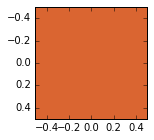

tensorflow orange, rgb: (216, 107, 51)


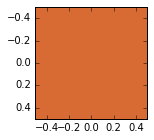

adfgasdgasd, rgb: (181, 182, 141)


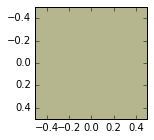

purple blue, rgb: (106, 96, 217)


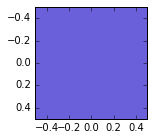

purple red, rgb: (230, 53, 102)


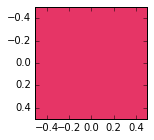

purple, rgb: (101, 23, 155)


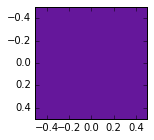

water, rgb: (207, 197, 201)


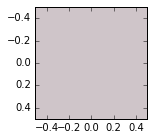

pink, rgb: (271, 151, 192)


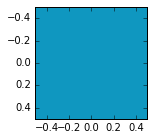

rock, rgb: (95, 54, 38)


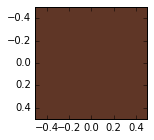

In [21]:
def predict(estimator, input_file):
    preds = estimator.predict(input_fn=get_input_fn(input_file, 1, shuffle=False))
    color_names = _get_csv_column(input_file, 'name')

    print()
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        print(name + ',', 'rgb:', color)
        _plot_rgb(p)
    
predict(estimator, MY_TEST_INPUT)

## Pre-trained model predictions

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'pretrained', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-10020
orange, rgb: (249, 89, 4)


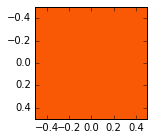

tensorflow orange, rgb: (243, 99, 40)


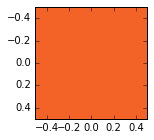

adfgasdgasd, rgb: (172, 152, 103)


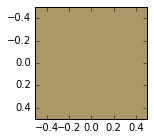

purple blue, rgb: (56, 50, 214)


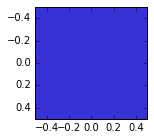

purple red, rgb: (168, 20, 69)


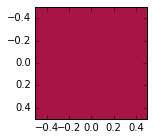

purple, rgb: (133, 49, 193)


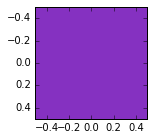

water, rgb: (148, 218, 240)


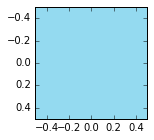

pink, rgb: (247, 123, 182)


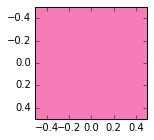

rock, rgb: (111, 46, 57)


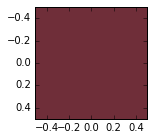

In [14]:
pre_estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
predict(pre_estimator, MY_TEST_INPUT)